In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import yfinance as yf

tickers = ['%5EGSPTSE','%5EGSPC','%5ESTOXX','000001.SS']
OHLC={}
for ticker in tickers:
    data = yf.download(ticker,start="2006-09-27",end="2020-09-29",interval="1d")
    OHLC[ticker]=data

ICP = pd.DataFrame({'SP500':    OHLC['%5EGSPC']['Adj Close'],
                    'TSX':      OHLC['%5EGSPTSE']['Adj Close'],
                    'STOXX600': OHLC['%5ESTOXX']['Adj Close'],
                    'SSE':      OHLC['000001.SS']['Adj Close']}).ffill()

# since last commit, yahoo finance decided to mess up (more) some of the tickers data, so now we have to drop rows...
ICP = ICP.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
BuyHold_SP     = (ICP['SP500']    /float(ICP['SP500'].iloc[0]))   -1
BuyHold_TSX    = (ICP['TSX']      /float(ICP['TSX'].iloc[0]))     -1
BuyHold_STOXX  = (ICP['STOXX600'] /float(ICP['STOXX600'].iloc[0]))-1
BuyHold_SSE    = (ICP['SSE']      /float(ICP['SSE'].iloc[0]))     -1

BuyHold_25Each = BuyHold_SP*(1/4) + BuyHold_TSX*(1/4) + BuyHold_STOXX*(1/4) + BuyHold_SSE*(1/4)

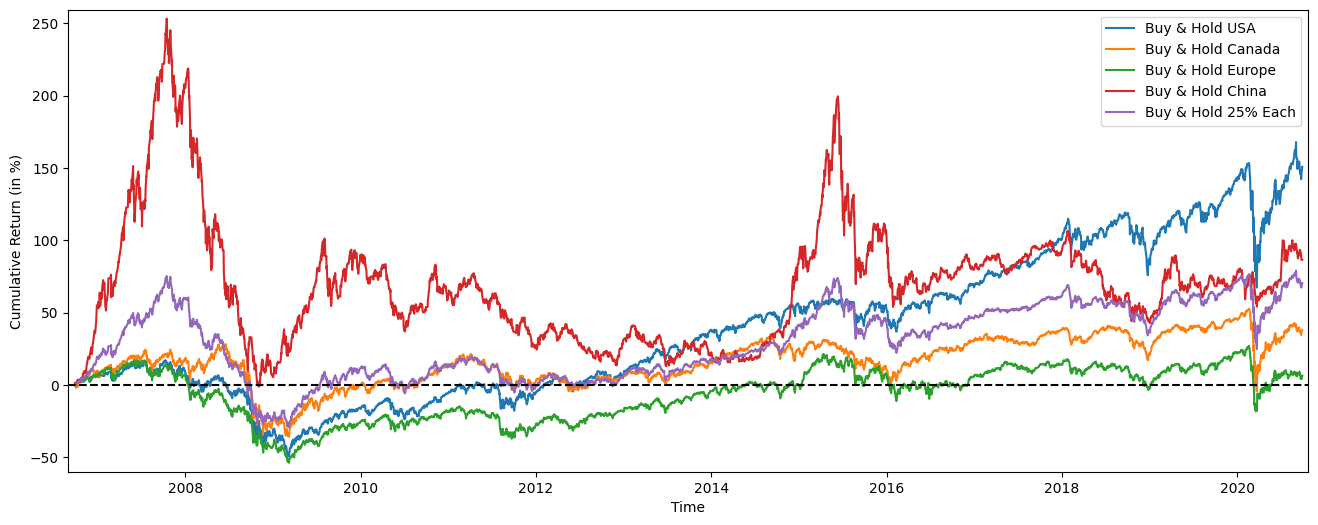

In [3]:

plt.figure(figsize=(16,6))
plt.plot(BuyHold_SP*100,     label='Buy & Hold USA')
plt.plot(BuyHold_TSX*100,    label='Buy & Hold Canada')
plt.plot(BuyHold_STOXX*100,  label='Buy & Hold Europe')
plt.plot(BuyHold_SSE*100,    label='Buy & Hold China')
plt.plot(BuyHold_25Each*100, label='Buy & Hold 25% Each')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [4]:
SP1Y     = ICP['SP500']    /ICP['SP500'].shift(252)   -1
TSX1Y    = ICP['TSX']      /ICP['TSX'].shift(252)     -1
STOXX1Y  = ICP['STOXX600'] /ICP['STOXX600'].shift(252)-1
SSE1Y    = ICP['SSE']      /ICP['SSE'].shift(252)     -1
Each251Y = SP1Y*(1/4) + TSX1Y*(1/4) +STOXX1Y*(1/4) + SSE1Y*(1/4)

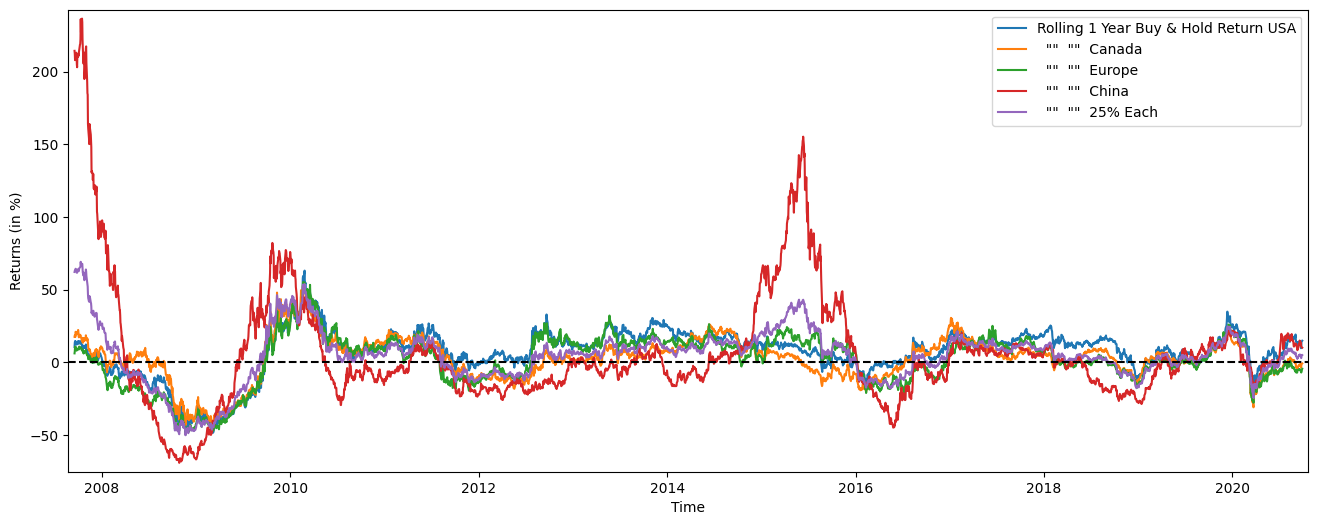

In [5]:
plt.figure(figsize=(16,6))
plt.plot(SP1Y*100,     label='Rolling 1 Year Buy & Hold Return USA')
plt.plot(TSX1Y*100,    label='  ""  ""  Canada')
plt.plot(STOXX1Y*100,  label='  ""  ""  Europe')
plt.plot(SSE1Y*100,    label='  ""  ""  China')
plt.plot(Each251Y*100, label='  ""  ""  25% Each')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [6]:
marr      = 0 #minimal acceptable rate of return (usually equal to the risk free rate)
SP1YS     = (SP1Y.mean()    -marr) /SP1Y.std()
TSX1YS    = (TSX1Y.mean()   -marr) /TSX1Y.std()
STOXX1YS  = (STOXX1Y.mean() -marr) /STOXX1Y.std()
SSE1YS    = (SSE1Y.mean()   -marr) /SSE1Y.std()
Each251YS = (Each251Y.mean()-marr) /Each251Y.std()

print('SP500 1 Year Buy & Hold Sharpe Ratio =',round(SP1YS,2))
print('TSX      "" "" =',round(TSX1YS   ,2))
print('STOXX600 "" "" =',round(STOXX1YS ,2))
print('SSE      "" "" =',round(SSE1YS   ,2))
print('25% Each "" "" =',round(Each251YS,2))

SP500 1 Year Buy & Hold Sharpe Ratio = 0.45
TSX      "" "" = 0.17
STOXX600 "" "" = 0.09
SSE      "" "" = 0.14
25% Each "" "" = 0.24


In [7]:
from scipy.optimize import minimize

def multi(x):
    a, b, c, d = x
    return a, b, c, d

def maximize_sharpe(x):
    weights = (SP1Y*multi(x)[0] + TSX1Y*multi(x)[1]
               + STOXX1Y*multi(x)[2] + SSE1Y*multi(x)[3])
    return -(weights.mean()/weights.std())

def constraint(x):
    return 1 - (multi(x)[0]+multi(x)[1]+multi(x)[2]+multi(x)[3])

cons = ({'type':'ineq','fun':constraint})
bnds = ((0,1),(0,1),(0,1),(0,1))
initial_guess = (1, 0, 0, 0)


ms = minimize(maximize_sharpe, initial_guess, method='SLSQP',
              bounds=bnds, constraints=cons, options={'maxiter': 10000})

msBuyHoldAll = (BuyHold_SP*ms.x[0] + BuyHold_TSX*ms.x[1]
                + BuyHold_STOXX*ms.x[2] + BuyHold_SSE*ms.x[3])

msBuyHold1yAll = (SP1Y*ms.x[0] + TSX1Y*ms.x[1]
                   + STOXX1Y*ms.x[2] + SSE1Y*ms.x[3])

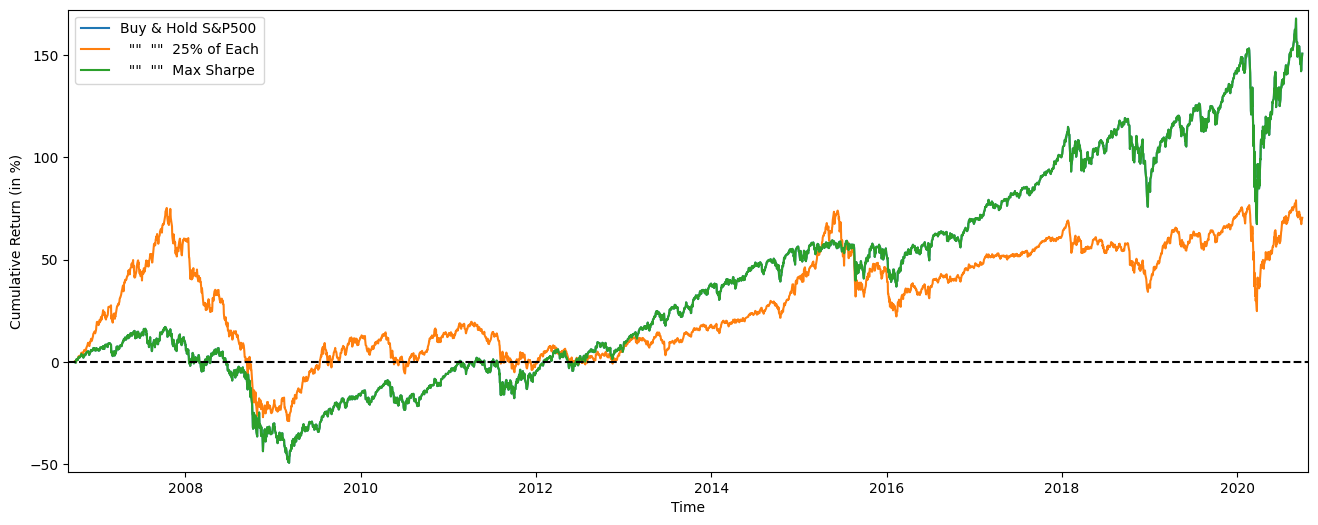

SP500 Weight = 100.0 %
TSX ""       = 0.0 %
STOXX600 ""  = 0.0 %
SSE ""       = 0.0 %

Sharpe = 0.454

Median yearly excess return over SP500 = 0.0 %


In [8]:
plt.figure(figsize=(16,6))
plt.plot(BuyHold_SP*100,     label='Buy & Hold S&P500')
plt.plot(BuyHold_25Each*100, label='  ""  ""  25% of Each')
plt.plot(msBuyHoldAll*100,   label='  ""  ""  Max Sharpe')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print('SP500 Weight =',round(ms.x[0]*100,2),'%')
print('TSX ""       =',round(ms.x[1]*100,2),'%')
print('STOXX600 ""  =',round(ms.x[2]*100,2),'%')
print('SSE ""       =',round(ms.x[3]*100,2),'%')
print()
print('Sharpe =',round(msBuyHold1yAll.mean()/msBuyHold1yAll.std(),3))
print()
print('Median yearly excess return over SP500 =',round((msBuyHold1yAll.median()-SP1Y.median())*100,1),'%')

In [10]:
def maximize_median_yearly_return(x): #different objective function
    weights = (SP1Y*multi(x)[0] + TSX1Y*multi(x)[1]
               + STOXX1Y*multi(x)[2] + SSE1Y*multi(x)[3])
    return -(float(weights.median()))

mm = minimize(maximize_median_yearly_return, initial_guess, method='SLSQP',
              bounds=bnds, constraints=cons, options={'maxiter': 10000})

mmBuyHoldAll = (BuyHold_SP*mm.x[0] + BuyHold_TSX*mm.x[1]
                + BuyHold_STOXX*mm.x[2] + BuyHold_SSE*mm.x[3])

mmBuyHold1yAll = (SP1Y*mm.x[0] + TSX1Y*mm.x[1]
                   + STOXX1Y*mm.x[2] + SSE1Y*mm.x[3])

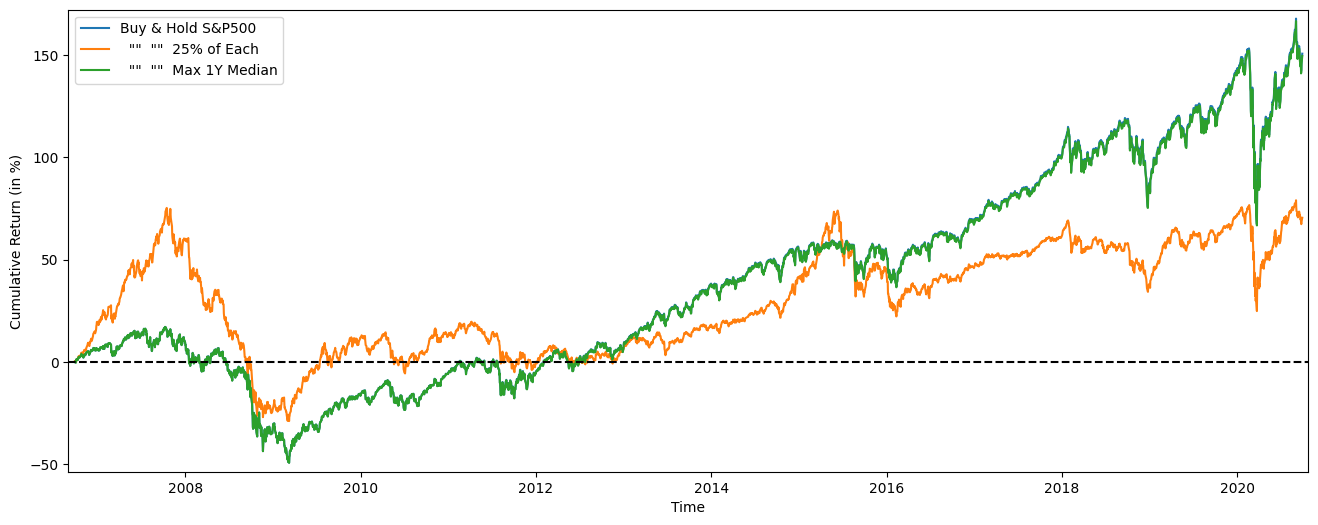

SP500 Weight = 99.22 %
TSX ""       = 0.0 %
STOXX600 ""  = 0.78 %
SSE ""       = 0.0 %

Sharpe = 0.451

Median yearly excess return over SP500 = 0.0 %


In [11]:
plt.figure(figsize=(16,6))
plt.plot(BuyHold_SP*100,     label='Buy & Hold S&P500')
plt.plot(BuyHold_25Each*100, label='  ""  ""  25% of Each')
plt.plot(mmBuyHoldAll*100,   label='  ""  ""  Max 1Y Median')
plt.xlabel('Time')
plt.ylabel('Cumulative Return (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print('SP500 Weight =',round(mm.x[0]*100,2),'%')
print('TSX ""       =',round(mm.x[1]*100,2),'%')
print('STOXX600 ""  =',round(mm.x[2]*100,2),'%')
print('SSE ""       =',round(mm.x[3]*100,2),'%')
print()
print('Sharpe =',round(mmBuyHold1yAll.mean()/mmBuyHold1yAll.std(),3))
print()
print('Median yearly excess return over SP500 =',round((mmBuyHold1yAll.median()-SP1Y.median())*100,1),'%')